<a href="https://colab.research.google.com/github/ChamodKalupahana/simulating_the_universe_using_GANs/blob/main/Plotting_power_spectra_and_single_map_figures_for_U_net_and_diffusion_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting power strecpa for Diffusion vs U-net

### Import modules

In [ ]:
# !pip install google-colab-auth
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
# from google.colab import auth
# auth.authenticate_user()


Mounted at /content/drive


### Load data

In [ ]:
n_body_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_n_body_to_M_Z_1000_images.npy'

ARU_net_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/attention_resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy'
ARU_net_diffusion_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_cham_u_net_20_epochs_M_Z_predictions_1000_images.npy'# has different n=body inputs, re-do without shuffle
RU_net_diffusion_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_M_Z_predictions_1000_images.npy'

hydro_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images.npy'

number_of_images = 1000

ds_nbody = np.load(n_body_file_path)
ds_nbody = np.squeeze(ds_nbody[0:number_of_images])

ARU_net_ds_Mz_predictions = np.load(ARU_net_predictions_file_path)
ARU_net_ds_Mz_predictions = np.squeeze(ARU_net_ds_Mz_predictions[0:number_of_images], axis=-1)

ARU_net_diffusion_ds_Mz_predictions = np.load(ARU_net_diffusion_predictions_file_path)
ARU_net_diffusion_ds_Mz_predictions = np.squeeze(ARU_net_diffusion_ds_Mz_predictions[0:number_of_images], axis=-1)

RU_net_diffusion_ds_Mz_predictions = np.load(RU_net_diffusion_predictions_file_path)
RU_net_diffusion_ds_Mz_predictions = np.squeeze(RU_net_diffusion_ds_Mz_predictions[0:number_of_images], axis=-1)

ds_Mz_truth = np.load(hydro_file_path)
ds_Mz_truth = np.squeeze(ds_Mz_truth[0:number_of_images], axis=-1)

Nx = ds_Mz_truth.shape[-1] # 256, since ds_Mz_truth has shape (100, 256, 256)
kvals = np.arange(0, Nx / 2)

Text(0.5, 1.0, 'Hydro')

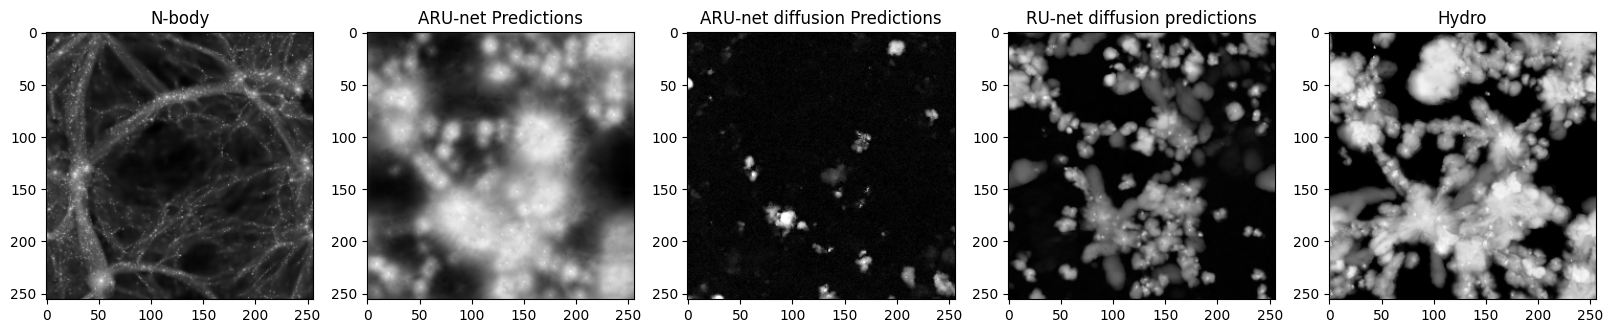

In [ ]:
# check data
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(ds_nbody[0], cmap='gray')
ax[1].imshow(ARU_net_ds_Mz_predictions[0], cmap='gray')
ax[2].imshow(ARU_net_diffusion_ds_Mz_predictions[0], cmap='gray')
ax[3].imshow(RU_net_diffusion_ds_Mz_predictions[0], cmap='gray')
ax[4].imshow(ds_Mz_truth[0], cmap='gray')

ax[0].set_title('N-body')
ax[1].set_title('ARU-net Predictions')
ax[2].set_title('ARU-net diffusion Predictions')
ax[3].set_title('RU-net diffusion predictions')
ax[4].set_title('Hydro')

In [ ]:
!pip install quantimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 85.9 MB/s eta 0:00:00


### Plot figure

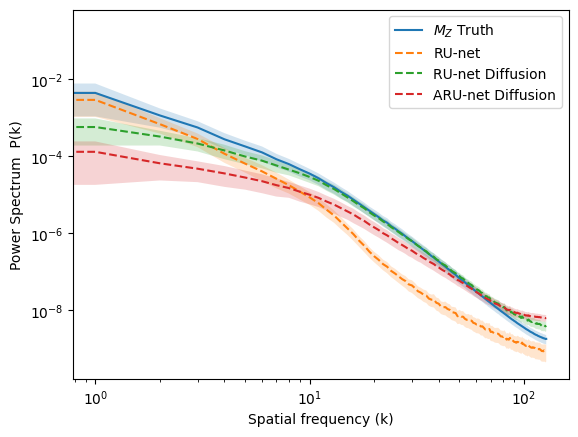

In [ ]:
# Code from GitHub

from quantimpy import minkowski as mk

# def calc_1dps_img2d(img, smoothed=0.5):
#     img = np.squeeze(img)
#     Nx = img.shape[0]
#     kvals = np.arange(0, Nx / 2)
#     fft_zerocenter = np.fft.fftshift(np.fft.fft2(img) / Nx ** 2)
#     impf = abs(fft_zerocenter) ** 2.0
#     x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
#     R = np.sqrt((x - (Nx / 2)) ** 2 + (y - (Nx / 2)) ** 2)
#     filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
#     mean = np.vectorize(filt)(kvals)
#     return kvals, mean
 
def calc_1dps_img2d(kvals, img, smoothed=0.5):
    """Compute the power spectrum of a single input image"""
    # print("calc_1dps input image shape is: ", img.shape)
    Nx = img.shape[0]
    # print("Nx is ", Nx)
    fft_zerocenter = np.fft.fftshift(np.fft.fft2(img)/Nx**2) #Aug
    impf = abs(fft_zerocenter) ** 2.0
    x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
    R  = np.sqrt((x-(Nx/2))**2+(y-(Nx/2))**2) #Aug
    filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
    mean = np.vectorize(filt)(kvals)
    return mean


def get_minkowski(img, min=-1, max=1):
    img = np.squeeze(img)
    gs_vals = np.linspace(min, max, 50)
    gs_masks = [img >= gs_vals[ig] for ig in range(len(gs_vals))]
    minkowski = []
    for i in range(len(gs_masks)):
        minkowski.append(mk.functionals(gs_masks[i], norm=True))
    return np.vstack(minkowski)


# def populate_samplist(img_list_a, img_list_b):
#   """Populates a samplist array with N image power spectra"""
#     samplist = []
#     Nx = img_list[0].shape[0]
#     kvals = np.arange(0, Nx / 2)
#     for img in img_list:
#       spec = calc_1dps_img2d(kvals, img)
#       samplist.append(spec)

#     return samplist


# samplist = populate_samplist(ds_truth[0:100]) # power spectra of 100 images in ds_truth


def get_powspec_for_samples(samplist):
    ps_list = []
    Nx = samplist[0].shape[-1] # Nx=256
    kvals = np.arange(0, Nx/2)
    # print("samplist shape is: ",samplist.shape)
    for samp in samplist:
        assert len(samp.shape)==3
        assert samp.shape[-1]==Nx
        assert samp.shape[-2]==Nx
        # print("samp shape is: ", samp.shape)
        pssamp = np.vstack([calc_1dps_img2d(kvals, samp[ci, ...], smoothed=0.25) for ci in range(samp.shape[0])])
        ps_list.append(pssamp)
    return ps_list # removed the return of kvals

# cols=['b', 'r']
def plot_ps_samples(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='solid' if isd==0 else 'dashed'
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'k')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'P(k)')
    plt.legend()
    # plt.show()
    return

def plot_ps_samples_M_Z_data(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='dashed' # changed from M_Z_truth function
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'Spatial frequency (k)')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'Power Spectrum  P(k)')
    plt.legend()
    # plt.show()
    return


RUnet_Mz_samplist = np.stack((ds_Mz_truth, ARU_net_ds_Mz_predictions)) # list of two (100, 256, 256) samples
RU_net_ps_list = get_powspec_for_samples(RUnet_Mz_samplist)
plot_ps_samples(kvals, RU_net_ps_list, names=["$M_Z$ Truth", "RU-net"])

Cham_net_Mz_samplist = np.stack((RU_net_diffusion_ds_Mz_predictions, ARU_net_diffusion_ds_Mz_predictions)) # list of two (100, 256, 256) samples
Cham_net_ps_list = get_powspec_for_samples(Cham_net_Mz_samplist)
plot_ps_samples_M_Z_data(kvals, Cham_net_ps_list, names=["RU-net Diffusion", "ARU-net Diffusion"])

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/Diffusion vs RU-net Power spectrum of M_Z 1000 images.jpg', dpi=1000)
plt.show()

# Plotting power strecpa for Vanilla vs Residual vs Attention U-net

### Import modules

In [ ]:
# !pip install google-colab-auth
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
# from google.colab import auth
# auth.authenticate_user()


Mounted at /content/drive


### Load data

In [ ]:
n_body_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images.npy'

RU_net_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy'
Cham_net_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/attention_resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy'
Vanilla_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/vanilla_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy' 

hydro_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images.npy'

number_of_images = 1000

ds_nbody = np.load(n_body_file_path)
ds_nbody = np.squeeze(ds_nbody[0:number_of_images])

RU_net_ds_Mz_predictions = np.load(RU_net_predictions_file_path)
RU_net_ds_Mz_predictions = np.squeeze(RU_net_ds_Mz_predictions[0:number_of_images], axis=-1)

Cham_net_ds_Mz_predictions = np.load(Cham_net_predictions_file_path)
Cham_net_ds_Mz_predictions = np.squeeze(Cham_net_ds_Mz_predictions[0:number_of_images], axis=-1)

Vanilla_net_ds_Mz_predictions = np.load(Vanilla_file_path)
Vanilla_net_ds_Mz_predictions = np.squeeze(Vanilla_net_ds_Mz_predictions[0:number_of_images], axis=-1)

ds_Mz_truth = np.load(hydro_file_path)
ds_Mz_truth = np.squeeze(ds_Mz_truth[0:number_of_images], axis=-1)

Nx = ds_Mz_truth.shape[-1] # 256, since ds_Mz_truth has shape (100, 256, 256)
kvals = np.arange(0, Nx / 2)

Text(0.5, 1.0, 'Hydro')

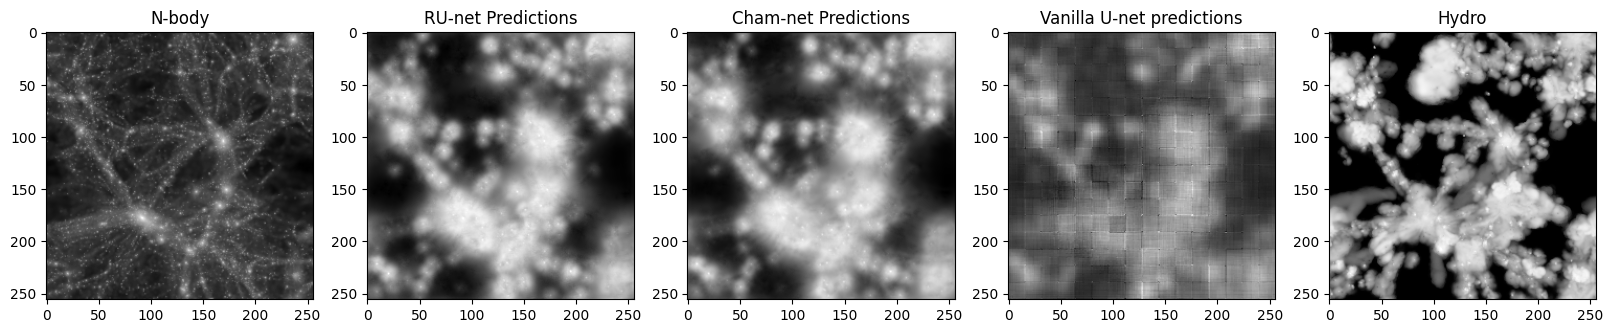

In [ ]:
# check data
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(ds_nbody[0], cmap='gray')
ax[1].imshow(RU_net_ds_Mz_predictions[0], cmap='gray')
ax[2].imshow(Cham_net_ds_Mz_predictions[0], cmap='gray')
ax[3].imshow(Cham_net_no_diffusion_ds_Mz_predictions[0], cmap='gray')
ax[4].imshow(ds_Mz_truth[0], cmap='gray')

ax[0].set_title('N-body')
ax[1].set_title('RU-net Predictions')
ax[2].set_title('Cham-net Predictions')
ax[3].set_title('Vanilla U-net predictions')
ax[4].set_title('Hydro')

In [ ]:
!pip install quantimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 76.7 MB/s eta 0:00:00


### Plot figure

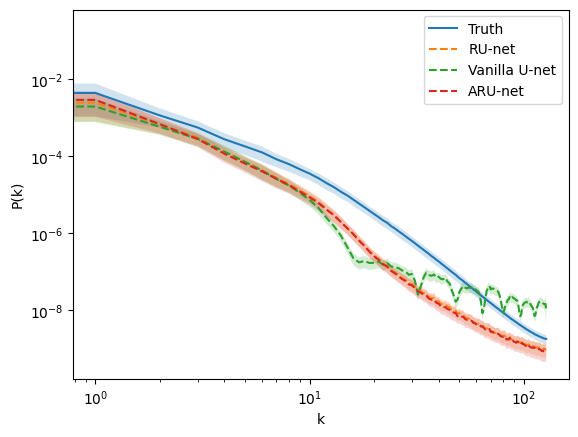

In [ ]:
# Code from GitHub

from quantimpy import minkowski as mk

# def calc_1dps_img2d(img, smoothed=0.5):
#     img = np.squeeze(img)
#     Nx = img.shape[0]
#     kvals = np.arange(0, Nx / 2)
#     fft_zerocenter = np.fft.fftshift(np.fft.fft2(img) / Nx ** 2)
#     impf = abs(fft_zerocenter) ** 2.0
#     x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
#     R = np.sqrt((x - (Nx / 2)) ** 2 + (y - (Nx / 2)) ** 2)
#     filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
#     mean = np.vectorize(filt)(kvals)
#     return kvals, mean
 
def calc_1dps_img2d(kvals, img, smoothed=0.5):
    """Compute the power spectrum of a single input image"""
    # print("calc_1dps input image shape is: ", img.shape)
    Nx = img.shape[0]
    # print("Nx is ", Nx)
    fft_zerocenter = np.fft.fftshift(np.fft.fft2(img)/Nx**2) #Aug
    impf = abs(fft_zerocenter) ** 2.0
    x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
    R  = np.sqrt((x-(Nx/2))**2+(y-(Nx/2))**2) #Aug
    filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
    mean = np.vectorize(filt)(kvals)
    return mean


def get_minkowski(img, min=-1, max=1):
    img = np.squeeze(img)
    gs_vals = np.linspace(min, max, 50)
    gs_masks = [img >= gs_vals[ig] for ig in range(len(gs_vals))]
    minkowski = []
    for i in range(len(gs_masks)):
        minkowski.append(mk.functionals(gs_masks[i], norm=True))
    return np.vstack(minkowski)


# def populate_samplist(img_list_a, img_list_b):
#   """Populates a samplist array with N image power spectra"""
#     samplist = []
#     Nx = img_list[0].shape[0]
#     kvals = np.arange(0, Nx / 2)
#     for img in img_list:
#       spec = calc_1dps_img2d(kvals, img)
#       samplist.append(spec)

#     return samplist


# samplist = populate_samplist(ds_truth[0:100]) # power spectra of 100 images in ds_truth


def get_powspec_for_samples(samplist):
    ps_list = []
    Nx = samplist[0].shape[-1] # Nx=256
    kvals = np.arange(0, Nx/2)
    # print("samplist shape is: ",samplist.shape)
    for samp in samplist:
        assert len(samp.shape)==3
        assert samp.shape[-1]==Nx
        assert samp.shape[-2]==Nx
        # print("samp shape is: ", samp.shape)
        pssamp = np.vstack([calc_1dps_img2d(kvals, samp[ci, ...], smoothed=0.25) for ci in range(samp.shape[0])])
        ps_list.append(pssamp)
    return ps_list # removed the return of kvals

# cols=['b', 'r']
def plot_ps_samples_M_Z_truth(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='solid' if isd==0 else 'dashed'
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'k')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'P(k)')
    plt.legend()
    # plt.show()
    return

def plot_ps_samples_M_Z_data(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='dashed' # changed from M_Z_truth function
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'k')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'P(k)')
    plt.legend()
    # plt.show()
    return



RUnet_Mz_samplist = np.stack((ds_Mz_truth, RU_net_ds_Mz_predictions)) # list of two (100, 256, 256) samples
RU_net_ps_list = get_powspec_for_samples(RUnet_Mz_samplist)
plot_ps_samples_M_Z_truth(kvals, RU_net_ps_list, names=["Truth", "RU-net"])

Cham_net_Mz_samplist = np.stack((Vanilla_net_ds_Mz_predictions, Cham_net_ds_Mz_predictions)) # list of two (100, 256, 256) samples
Cham_net_ps_list = get_powspec_for_samples(Cham_net_Mz_samplist)
plot_ps_samples_M_Z_data(kvals, Cham_net_ps_list, names=["Vanilla U-net", "ARU-net"])

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/ARU-net, RU-net, Vanilla U-net Power spectrum of M_Z and predictions 1000 images.jpg', dpi=1000)
plt.show()



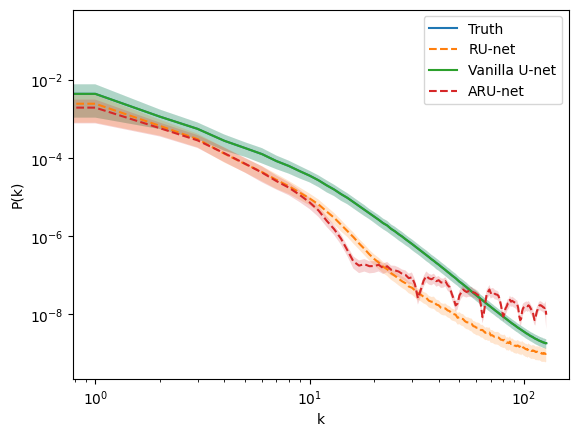

In [ ]:
# check if M_Z is needed for each plotting (not needed after checking)


RUnet_Mz_samplist = np.stack((ds_Mz_truth, RU_net_ds_Mz_predictions)) # list of two (100, 256, 256) samples
RU_net_ps_list = get_powspec_for_samples(RUnet_Mz_samplist)
plot_ps_samples(kvals, RU_net_ps_list, names=["Truth", "RU-net"])

Cham_net_Mz_samplist = np.stack((ds_Mz_truth, Vanilla_net_ds_Mz_predictions,)) # list of two (100, 256, 256) samples
Cham_net_ps_list = get_powspec_for_samples(Cham_net_Mz_samplist)
plot_ps_samples(kvals, Cham_net_ps_list, names=["Vanilla U-net", "ARU-net"])

#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/Power spectrum of M_Z and predictions.jpg', dpi=1000)
plt.show()

# Plotting Vanilla vs Residual vs Attention U-net figure for same M_Z and M_tot map

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Mounted at /content/drive


### Load data

In [ ]:
M_tot = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_tot_1000_images.npy")
M_Z = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images.npy")

Vanilla_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/vanilla_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy")
Vanilla_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/vanilla_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images.npy")

Residual_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy")
Residual_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images.npy")

Attention_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/attention_resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy")
Attention_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/attention_resdiual_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images.npy")

### Plot figure

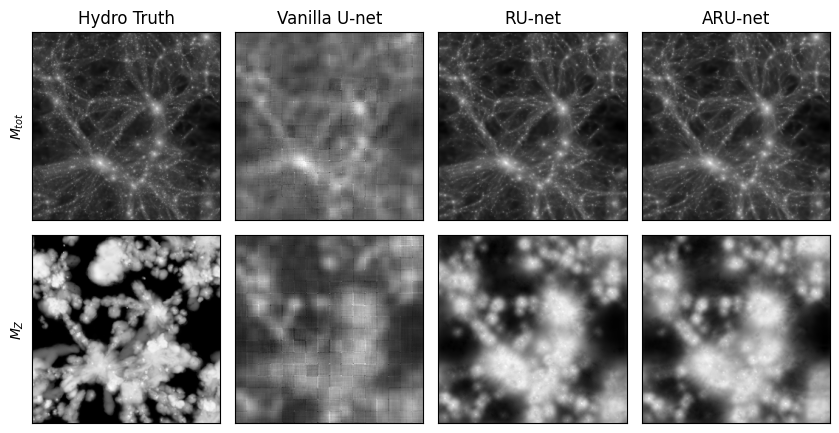

In [ ]:
columns = 4
rows = 2

fig, ax = plt.subplots(rows, columns, figsize=(8.5, 4.5))

cmap = 'gray'

# plot truth maps

ax[0,0].imshow(M_tot[0], cmap=cmap)
ax[1,0].imshow(M_Z[0], cmap=cmap)


# plot prediction maps
ax[0,1].imshow(Vanilla_U_net_M_tot_predictions[0], cmap=cmap)
ax[0,2].imshow(Residual_U_net_M_tot_predictions[0], cmap=cmap)
ax[0,3].imshow(Attention_U_net_M_tot_predictions[0], cmap=cmap)

ax[1,1].imshow(Vanilla_U_net_M_Z_predictions[0], cmap=cmap)
ax[1,2].imshow(Residual_U_net_M_Z_predictions[0], cmap=cmap)
ax[1,3].imshow(Attention_U_net_M_Z_predictions[0], cmap=cmap)

# plotting labels
ax[0,0].set_title('Hydro Truth')
ax[0,1].set_title('Vanilla U-net')
ax[0,2].set_title('RU-net')
ax[0,3].set_title('ARU-net')

ax[0,0].set_ylabel('$M_{tot}$')
ax[1,0].set_ylabel('$M_{Z}$')


for row in range(rows):
  for column in range(columns):
    ax[row, column].set_xticks([])
    ax[row, column].set_yticks([])

fig.tight_layout()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/ARU-net, RU-net, Vanilla U-net single M_Z and M_tot prediction.jpg', dpi=1000)

# Plotting Attention U-net vs Diffusion  figure for same M_Z and M_tot map

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [ ]:
M_tot = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_tot_1000_images.npy")
M_Z = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images.npy")

Residual_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_Z_predictions_1000_images.npy")
Residual_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images.npy")

Diffusion_residual_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_M_Z_predictions_1000_images.npy")
Diffusion_residual_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_M_tot_predictions_1000_images.npy")

Diffusion_attention_residual_U_net_M_Z_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_cham_u_net_20_epochs_M_Z_predictions_1000_images.npy")
Diffusion_attention_residual_U_net_M_tot_predictions = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_cham_u_net_20_epochs_M_tot_predictions_1000_images.npy")

### Plot figure

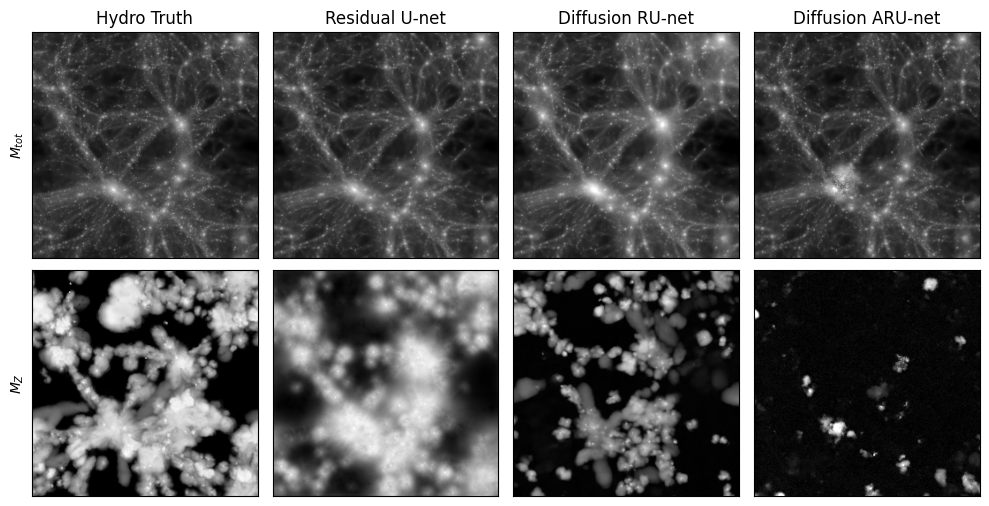

In [ ]:
columns = 4
rows = 2

fig, ax = plt.subplots(rows, columns, figsize=(10, 5.2))

cmap = 'gray'

# plot truth maps

ax[0,0].imshow(M_tot[0], cmap=cmap)
ax[1,0].imshow(M_Z[0], cmap=cmap)

# plot prediction maps
ax[0,1].imshow(Residual_U_net_M_tot_predictions[0], cmap=cmap)
ax[1,1].imshow(Residual_U_net_M_Z_predictions[0], cmap=cmap)

ax[0,2].imshow(Diffusion_residual_U_net_M_tot_predictions[0], cmap=cmap)
ax[1,2].imshow(Diffusion_residual_U_net_M_Z_predictions[0], cmap=cmap)

ax[0,3].imshow(Diffusion_attention_residual_U_net_M_tot_predictions[0], cmap=cmap)
ax[1,3].imshow(Diffusion_attention_residual_U_net_M_Z_predictions[0], cmap=cmap)


# plotting labels
ax[0,0].set_title('Hydro Truth')
ax[0,1].set_title('Residual U-net')
ax[0,2].set_title('Diffusion RU-net')
ax[0,3].set_title('Diffusion ARU-net')

ax[0,0].set_ylabel('$M_{tot}$')
ax[1,0].set_ylabel('$M_{Z}$')

for row in range(rows):
  for column in range(columns):
    ax[row, column].set_xticks([])
    ax[row, column].set_yticks([])

fig.tight_layout()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/RU-net, Diffusion RU-net, Diffusion ARU-net single M_Z and M_tot prediction.jpg', dpi=1000)

# Plotting Example fields figure for same N-body map

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Mounted at /content/drive


### Load data

In [ ]:
N_body = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images.npy")
M_gas = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_gas_1000_images.npy")
V_gas = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/V_gas_1000_images.npy")
T = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/T_1000_images.npy")
P = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/P_1000_images.npy")
M_Z = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images.npy")
HI = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/HI_1000_images.npy")
ne = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/ne_1000_images.npy")
B = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/B_1000_images.npy")
MgFe = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/MgFe_1000_images.npy")


M_star = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_star_1000_images.npy")
M_tot = np.load("/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_tot_1000_images.npy")



### Plot figure

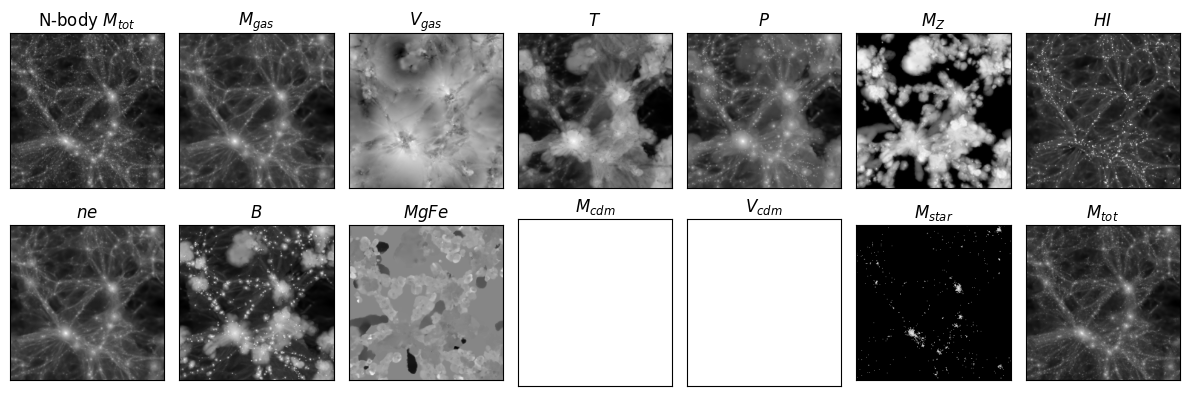

In [ ]:
columns = 7
rows = 2

fig, ax = plt.subplots(rows, columns, figsize=(12, 4))

cmap = 'gray'

# plot truth maps


ax[0,0].imshow(N_body[0], cmap=cmap)
ax[0,1].imshow(M_gas[0], cmap=cmap)
ax[0,2].imshow(V_gas[0], cmap=cmap)
ax[0,3].imshow(T[0], cmap=cmap)
ax[0,4].imshow(P[0], cmap=cmap)
ax[0,5].imshow(M_Z[0], cmap=cmap)
ax[0,6].imshow(HI[0], cmap=cmap)

ax[1,0].imshow(ne[0], cmap=cmap)
ax[1,1].imshow(B[0], cmap=cmap)
ax[1,2].imshow(MgFe[0], cmap=cmap)


ax[1,5].imshow(M_star[0], cmap=cmap)
ax[1,6].imshow(M_tot[0], cmap=cmap)

# plotting labels
ax[0,0].set_title('N-body $M_{tot}$')
ax[0,1].set_title('$M_{gas}$')
ax[0,2].set_title('$V_{gas}$')
ax[0,3].set_title('$T$')
ax[0,4].set_title('$P$')
ax[0,5].set_title('$M_{Z}$')
ax[0,6].set_title('$HI$')

ax[1,0].set_title('$ne$')
ax[1,1].set_title('$B$')
ax[1,2].set_title('$MgFe$')
ax[1,3].set_title('$M_{cdm}$')
ax[1,4].set_title('$V_{cdm}$')
ax[1,5].set_title('$M_{star}$')
ax[1,6].set_title('$M_{tot}$')

for row in range(rows):
  for column in range(columns):
    ax[row, column].set_xticks([])
    ax[row, column].set_yticks([])

fig.tight_layout()
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/RU-net, Diffusion RU-net, Diffusion ARU-net single M_Z and M_tot prediction.jpg', dpi=1000)

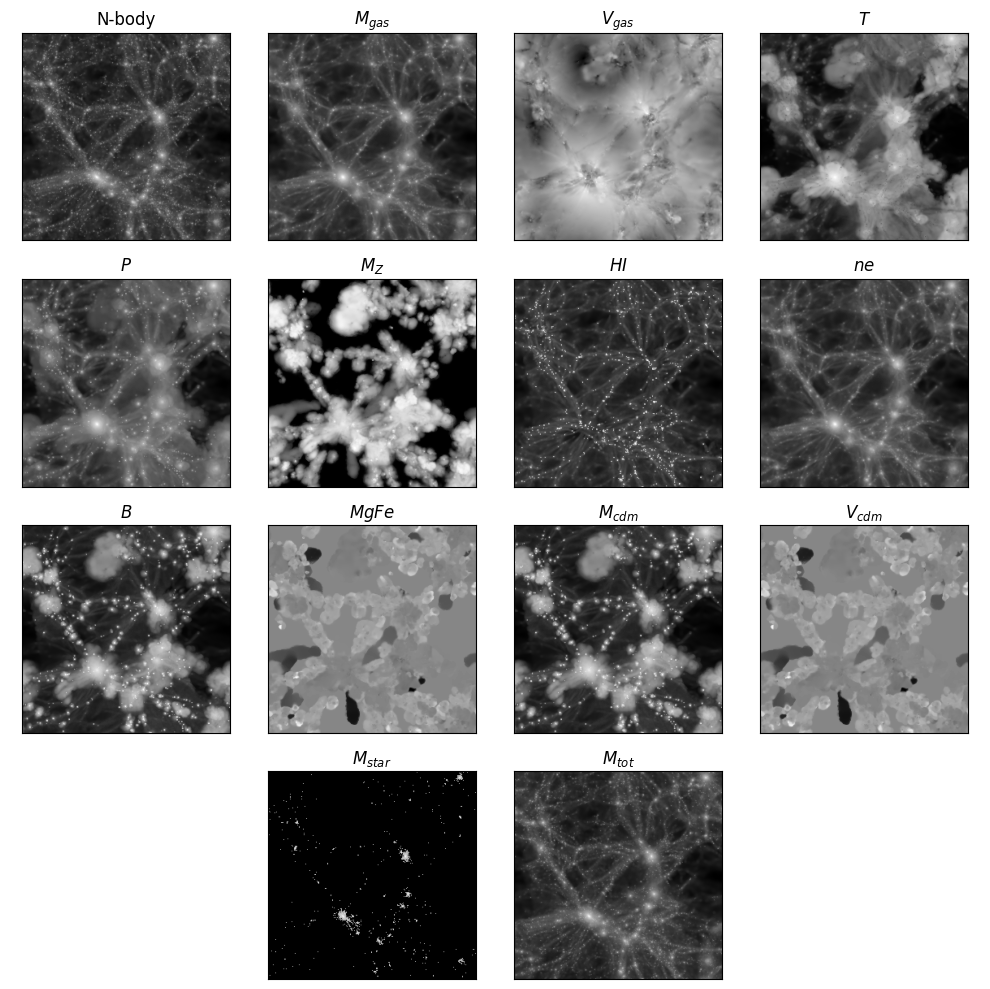

In [ ]:
columns = 4
rows = 4



fig, ax = plt.subplots(rows, columns, figsize=(10, 10))



cmap = 'gray'



# plot truth maps
ax[0, 0].imshow(N_body[0], cmap=cmap)
ax[0, 1].imshow(M_gas[0], cmap=cmap)
ax[0, 2].imshow(V_gas[0], cmap=cmap)
ax[0, 3].imshow(T[0], cmap=cmap)



ax[1, 0].imshow(P[0], cmap=cmap)
ax[1, 1].imshow(M_Z[0], cmap=cmap)
ax[1, 2].imshow(HI[0], cmap=cmap)
ax[1, 3].imshow(ne[0], cmap=cmap)



ax[2, 0].imshow(B[0], cmap=cmap)
ax[2, 1].imshow(MgFe[0], cmap=cmap)
ax[2, 2].imshow(B[0], cmap=cmap)
ax[2, 3].imshow(MgFe[0], cmap=cmap)



ax[3, 1].imshow(M_star[0], cmap=cmap)
ax[3, 2].imshow(M_tot[0], cmap=cmap)



# plotting labels
ax[0, 0].set_title('N-body')
ax[0, 1].set_title('$M_{gas}$')
ax[0, 2].set_title('$V_{gas}$')
ax[0, 3].set_title('$T$')



ax[1, 0].set_title('$P$')
ax[1, 1].set_title('$M_{Z}$')
ax[1, 2].set_title('$HI$')
ax[1, 3].set_title('$ne$')



ax[2, 0].set_title('$B$')
ax[2, 1].set_title('$MgFe$')
ax[2, 2].set_title('$M_{cdm}$')
ax[2, 3].set_title('$V_{cdm}$')


ax[3, 1].set_title('$M_{star}$')
ax[3, 2].set_title('$M_{tot}$')



# Remove empty plots on the last row
ax[3, 0].axis('off')
ax[3, 3].axis('off')



# Remove spines and ticks for empty plots
for column in [0, 3]:
  ax[3, column].spines['top'].set_visible(False)
  ax[3, column].spines['right'].set_visible(False)
  ax[3, column].spines['bottom'].set_visible(False)
  ax[3, column].spines['left'].set_visible(False)
  ax[3, column].patch.set_visible(False)
  ax[3, column].axis('off')



# Remove ticks for all other plots
for row in range(rows):
 for column in range(columns):
  ax[row, column].set_xticks([])
  ax[row, column].set_yticks([])



fig.tight_layout()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/Example fields.jpg', dpi=1000)